# comments generation with LSTM

In [1]:
import torch
import re
import os
from torch import nn
from d2l import torch as d2l

In [2]:
def read_commentsGen_lstm():
    """将时间机器数据集加载到文本行列表中"""
    with open(os.path.join("..\\dataTry\\codeReviewer\\commentsGeneration", 'valid_trainPair.txt'), 'r', encoding='utf-8') as f:
        return f.readlines()

def load_corpus_commentsGen_lstm(max_tokens=-1):
    """返回时间机器数据集的令牌索引和词汇表。"""
    lines = read_commentsGen_lstm()
    tokens = d2l.tokenize(lines, 'word')
    vocab = d2l.Vocab(tokens, min_freq=5)
    #由于时间机器数据集中的每一行文本不一定是句子或段落，将所有文本行展开为一个列表
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        """Defined in :numref:`sec_language_model`"""
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_commentsGen_lstm(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_commentsGen_lstm(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """返回时间机器数据集的迭代器和词汇表。"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens=5000)
    return data_iter, data_iter.vocab

In [3]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_commentsGen_lstm(batch_size, num_steps)

In [5]:
print(len(train_iter.corpus))
print(type(train_iter.corpus))
print(len(vocab))

train_iter.corpus[:20]

5000
<class 'list'>
11021


[1, 2, 72, 0, 4, 389, 5, 9, 1, 2, 5, 1, 2, 29, 0, 1, 2, 1, 8, 52]

In [21]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [22]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = d2l.train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('''NEWLINE_NJUPT ADD_NJUPT require 'socket' NEWLINE_NJUPT ADD_NJUPT NEWLINE_NJUPT KEEP_NJUPT module RSpec NEWLINE_NJUPT KEEP_NJUPT module Core NEWLINE_NJUPT KEEP_NJUPT class Runner '''))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('''NEWLINE_NJUPT ADD_NJUPT require 'socket' NEWLINE_NJUPT ADD_NJUPT NEWLINE_NJUPT KEEP_NJUPT module RSpec NEWLINE_NJUPT KEEP_NJUPT module Core NEWLINE_NJUPT KEEP_NJUPT class Runner '''))
    print(predict('''NEWLINE_NJUPT ADD_NJUPT require 'socket' NEWLINE_NJUPT ADD_NJUPT NEWLINE_NJUPT KEEP_NJUPT module RSpec NEWLINE_NJUPT KEEP_NJUPT module Core NEWLINE_NJUPT KEEP_NJUPT class Runner '''))

perplexity 62.7, 5981.3 tokens/sec on cuda:0
NEWLINE_N<unk>UPT<unk>ADD_N<unk>UPT<unk>require<unk>'socket'<unk>NEWLINE_N<unk>UPT<unk>ADD_N<unk>UPT<unk>NEWLINE_N<unk>UPT<unk>KEEP_N<unk>UPT<unk>module<unk>RSpec<unk>NEWLINE_N<unk>UPT<unk>KEEP_N<unk>UPT<unk>module<unk>Core<unk>NEWLINE_N<unk>UPT<unk>KEEP_N<unk>UPT<unk>class<unk>Runner<unk>,NEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPTKEEP_NJUPTNEWLINE_NJUPT
NEWLINE_N<unk>UPT<unk>ADD_N<unk>UPT<unk>require<unk>'socket'<unk>NEWLINE_N<unk>UPT<unk>ADD_N<unk>U

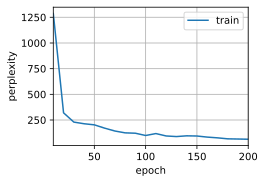

In [23]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 200, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params, init_lstm_state, lstm)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)